In [1]:
import sys
sys.path.append("/home/matt/portfolio/personal_portfolio/spotify")

import pandas as pd 
import numpy as np
import scipy.stats as stats

import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from src.processing import *
from src.wordcloud import *

In [2]:
# upload tracks and artists raw data
tracks = pd.read_csv('../data/tracks.csv')
artists = pd.read_csv('../data/artists.csv')

In [5]:
# process artists data (remove null genres, split genre tags, etc.)
cleaned_artists = clean_artists(artists)

# process tracks (clean strings, format datetime release date, etc.)
cleaned_tracks = clean_tracks(tracks)

1104349 total artists
298616 artists with labeled genres
459962 genre-artist pairs after processing


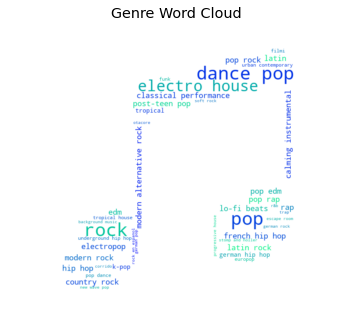

In [38]:
# generate word cloud of all genres
mask = '/home/matt/portfolio/personal_portfolio/spotify/img/note.png'
masked_wordcloud(cleaned_artists, mask, 'genres_wordcloud', min_font = 10, colormap_choice='winter')

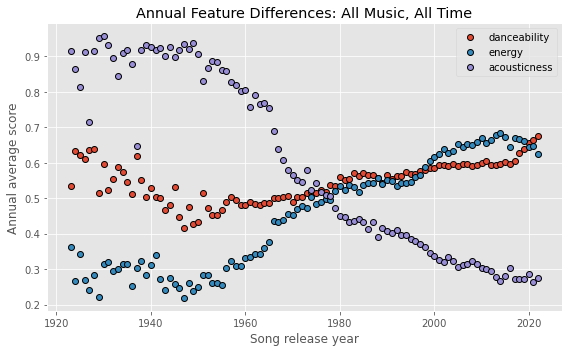

In [8]:
# how has music changed across all tracks, according to average annual track features?
tracks_release_year = cleaned_tracks.groupby('release_date').mean()
tracks_release_year = tracks_release_year.reset_index()
tracks_release_year = tracks_release_year[1:]

fig, ax = plt.subplots(figsize=[8,5])
ax.plot_date(tracks_release_year['release_date'], tracks_release_year['danceability'], label='danceability', markeredgecolor='black')
ax.plot_date(tracks_release_year['release_date'], tracks_release_year['energy'], label='energy', markeredgecolor='black')
ax.plot_date(tracks_release_year['release_date'], tracks_release_year['acousticness'], label='acousticness', markeredgecolor='black')
# ax.plot_date(tracks_release_year['release_date'], tracks_release_year['liveness'], label='liveness', markeredgecolor='black')
# ax.plot_date(tracks_release_year['release_date'], tracks_release_year['valence'], label='valence', markeredgecolor='black')
ax.legend()
ax.set_ylabel('Annual average score')
ax.set_xlabel('Song release year')
plt.title('Annual Feature Differences: All Music, All Time')
plt.tight_layout()
plt.savefig('/home/matt/portfolio/personal_portfolio/spotify/img/annual_avg_song_features.png')

acousticness p-value: 0.646
energy p-value: 0.349
liveness p-value: 0.225


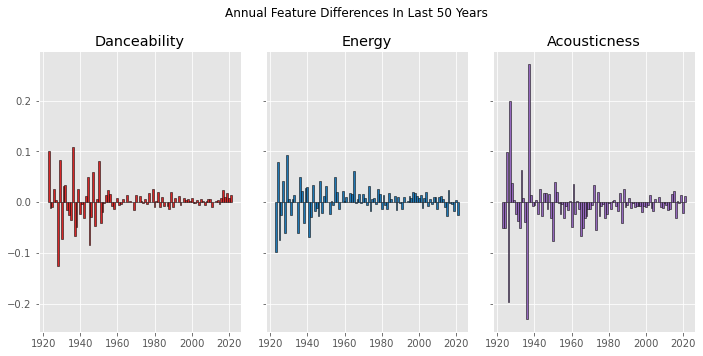

In [18]:
# visualizing annual differences for all genres, all time
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,5))
ax[0].bar(tracks_release_year['release_date'].astype(str).astype(int)[0:], tracks_release_year['danceability'].diff()[0:],width=1.0, color='tab:red', ec='black')
ax[0].set_title('Danceability')
ax[1].bar(tracks_release_year['release_date'].astype(str).astype(int)[0:], tracks_release_year['energy'].diff()[0:],width=1.0, color='tab:blue', ec='black')
ax[1].set_title('Energy')
ax[2].bar(tracks_release_year['release_date'].astype(str).astype(int)[0:], tracks_release_year['acousticness'].diff()[0:],width=1.0, color='tab:purple', ec='black')
ax[2].set_title('Acousticness')
plt.suptitle('Annual Feature Differences In Last 50 Years')
plt.tight_layout()
plt.savefig('/home/matt/portfolio/personal_portfolio/spotify/img/annual_avg_song_features_diffs.png')

# t-tests for all music, all time
print('acousticness p-value: {}'.format(round(stats.ttest_1samp(tracks_release_year['danceability'].diff()[1:],0, alternative='two-sided')[1], 3)))
print('energy p-value: {}'.format(round(stats.ttest_1samp(tracks_release_year['energy'].diff()[1:],0, alternative='two-sided')[1], 3)))
print('liveness p-value: {}'.format(round(stats.ttest_1samp(tracks_release_year['acousticness'].diff()[1:],0, alternative='two-sided')[1], 3)))

In [15]:
# merge tracks and artists data to analyze specific genres
tracks_artists = cleaned_artists.merge(cleaned_tracks, on='id_artists')

# rock music
rock_tracks = tracks_artists[tracks_artists['genres'] == 'rock']

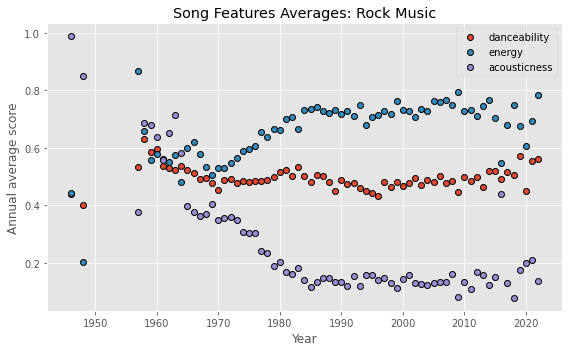

In [41]:
rock_tracks_avg = rock_tracks.groupby('release_date').mean().reset_index()[1:]

fig, ax = plt.subplots(figsize=[8,5])
ax.plot_date(rock_tracks_avg['release_date'], rock_tracks_avg['danceability'], label='danceability', markeredgecolor='black')
ax.plot_date(rock_tracks_avg['release_date'], rock_tracks_avg['energy'], label='energy', markeredgecolor='black')
ax.plot_date(rock_tracks_avg['release_date'], rock_tracks_avg['acousticness'], label='acousticness', markeredgecolor='black')
ax.legend()
ax.set_ylabel('Annual average score')
ax.set_xlabel('Year')
plt.title('Song Features Averages: Rock Music')
plt.tight_layout()
plt.savefig('/home/matt/portfolio/personal_portfolio/spotify/img/rock_song_features.png')

danceability p-value: 0.882
energy p-value: 0.078
acousticness p-value: 0.038


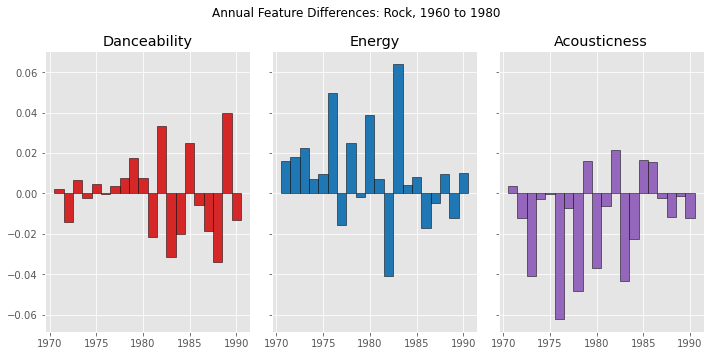

In [39]:
# t-tests for rock music

start = 15
end = 35

fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,5))
ax[0].bar(rock_tracks_avg['release_date'].astype(str).astype(int)[start:end], rock_tracks_avg['danceability'].diff()[start:end],width=1.0, color='tab:red', ec='black')
ax[0].set_title('Danceability')
ax[1].bar(rock_tracks_avg['release_date'].astype(str).astype(int)[start:end], rock_tracks_avg['energy'].diff()[start:end],width=1.0, color='tab:blue', ec='black')
ax[1].set_title('Energy')
ax[2].bar(rock_tracks_avg['release_date'].astype(str).astype(int)[start:end], rock_tracks_avg['acousticness'].diff()[start:end],width=1.0, color='tab:purple', ec='black')
ax[2].set_title('Acousticness')
plt.suptitle('Annual Feature Differences: Rock, 1960 to 1980')
plt.tight_layout()
plt.savefig('/home/matt/portfolio/personal_portfolio/spotify/img/rock_avg_song_features_diffs.png')

print('danceability p-value: {}'.format(round(stats.ttest_1samp(rock_tracks_avg['danceability'].diff()[start:end],0, alternative='two-sided')[1], 3)))
print('energy p-value: {}'.format(round(stats.ttest_1samp(rock_tracks_avg['energy'].diff()[start:end],0, alternative='two-sided')[1], 3)))
print('acousticness p-value: {}'.format(round(stats.ttest_1samp(rock_tracks_avg['acousticness'].diff()[start:end],0, alternative='two-sided')[1], 3)))

In [73]:
# look for track clusters using KMeans

# separate track training data and track labels
tracks_artists.columns
tracks_y = tracks_artists['genres']
tracks_X = tracks_artists[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']]

In [81]:
# use PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(2)
tracks_pca = pca.fit_transform(tracks_X)

In [90]:
# use KMeans to cluster 2d data

from sklearn.cluster import KMeans
k = 4
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(tracks_pca)

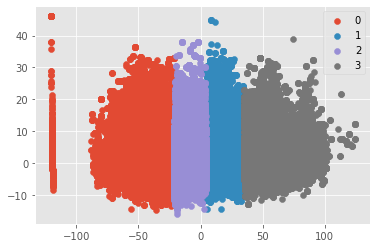

In [91]:
# visualize clusters
y_labels = np.unique(y_pred)
for i in y_labels:
    plt.scatter(tracks_pca[y_pred == i, 0], tracks_pca[y_pred == i, 1], label = i)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score()

In [ ]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
data = load_digits().data
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(data)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 10)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()